# 2. Cocacola

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
import warnings                
warnings.filterwarnings("ignore")

# Importing the Dataset

In [2]:
data = pd.read_excel(r'C:\Users\mukes\OneDrive\Desktop\Data Science\Assignments\Forecasting\CocaCola_Sales_Rawdata.xlsx')
data.head(3)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993


# Dataset Structure and Content

In [3]:
data.shape

(42, 2)

In [4]:
data.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


There are no missing values

In [6]:
# checking duplicates
data.duplicated().any()

False

No duplicates found

# Data Pre-Processing

In [7]:
# Creating dummies
# Extract the Quarter information from the 'Quarter' column
data['Quarter'] = data['Quarter'].str[0:2]

# Create dummy variables for the 'Quarter' column
dummy = pd.get_dummies(data['Quarter'], prefix='Quarter')

# Concatenate dummy variables with the original DataFrame
new_data = pd.concat([data, dummy], axis=1)

# Display the result
new_data.head()

,Quarter,Sales,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4
0,Q1,1734.827000,1,0,0,0
1,Q2,2244.960999,0,1,0,0
2,Q3,2533.804993,0,0,1,0
3,Q4,2154.962997,0,0,0,1
4,Q1,1547.818996,1,0,0,0


In [9]:
# finding t_squared values and log values
new_data["t"] = np.arange(1,43)
new_data["t_squared"] = new_data["t"]*new_data["t"]
new_data.columns
new_data["log_Sales"] = np.log(new_data["Sales"])
new_data.head()

,Quarter,Sales,Quarter_Q1,Quarter_Q2,Quarter_Q3,Quarter_Q4,t,t_squared,log_Sales
0,Q1,1734.827000,1,0,0,0,1,1,7.458663
1,Q2,2244.960999,0,1,0,0,2,4,7.716443
2,Q3,2533.804993,0,0,1,0,3,9,7.837477
3,Q4,2154.962997,0,0,0,1,4,16,7.675529
4,Q1,1547.818996,1,0,0,0,5,25,7.344602


# Visualizing the Time Series

<Axes: xlabel='Quarter', ylabel='Sales'>

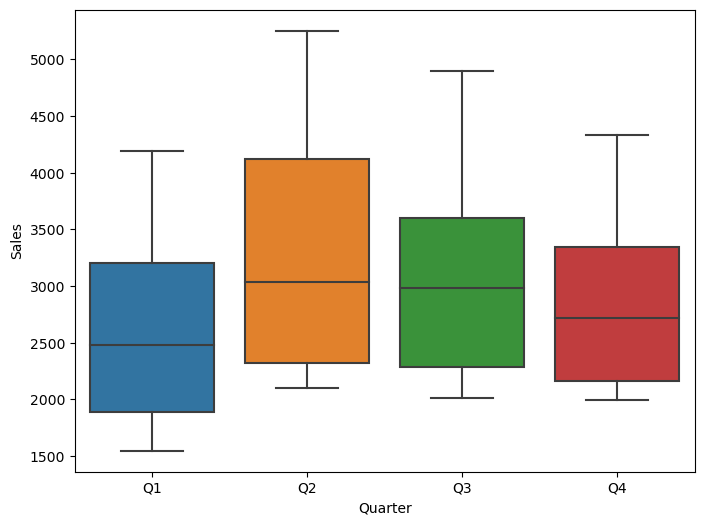

In [11]:
# Boxplot
plt.figure(figsize = (8,6))
sns.boxplot(x = "Quarter", y = "Sales", data = new_data)

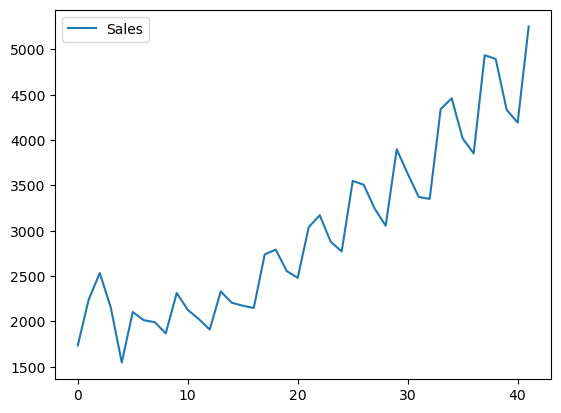

In [12]:
data.plot()
plt.show()

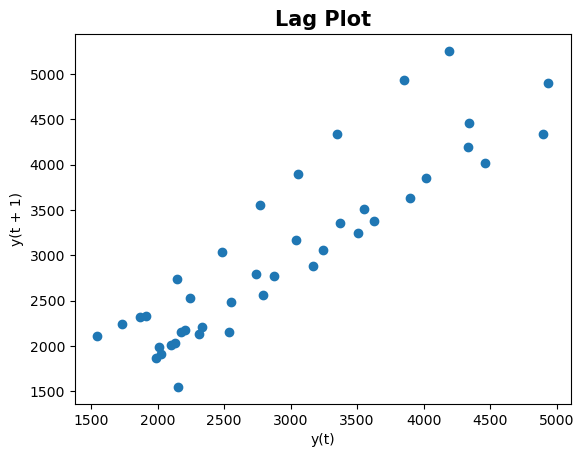

In [13]:
# lag plot to know the relationship
lag_plot(new_data['Sales'])
plt.title("Lag Plot", size = 15, weight = "bold")
plt.show()

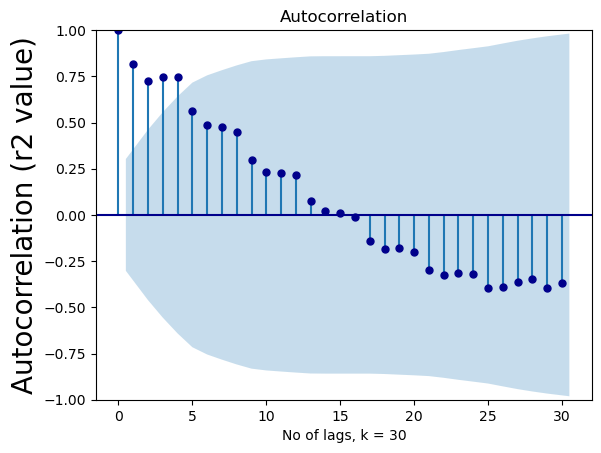

In [14]:
# AutoCorrelation Function plot
plot_acf(new_data['Sales'], lags = 30, color = 'darkblue')          # plotting for k = 30 lags 
plt.xlabel("No of lags, k = 30", size = 10)
plt.ylabel("Autocorrelation (r2 value)", size = 20)
plt.show()

<Axes: xlabel='Quarter', ylabel='Sales'>

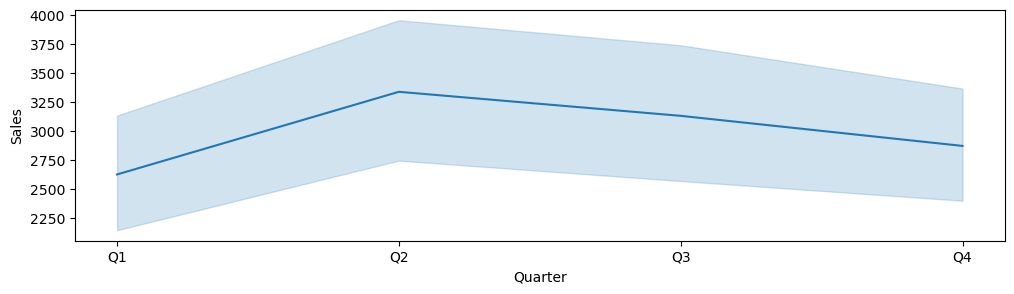

In [15]:
# plot lineplot with quarter and sales
plt.figure(figsize = (12,3))
sns.lineplot(x = "Quarter", y = "Sales", data = new_data)

# Splitting Data into train and test

In [16]:
# Splitting Data into train and test
train = new_data.head(29)
test  = new_data.tail(12)

In [17]:
train.shape, test.shape

((29, 9), (12, 9))

# 1. Linear Model

In [18]:
import statsmodels.formula.api as smf 
#linear model

linear = smf.ols('Sales~t',data=train).fit()
pred_linear =  pd.Series(linear.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_linear))**2))
rmse_linear

808.7073724654331

# 2. Quadratic

In [19]:
# quadratic model

Quad = smf.ols('Sales~t+t_squared',data=train).fit() #quadratic model
pred_Quad = pd.Series(Quad.predict(test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_Quad))**2))
print("Root Mean Square Error : ",rmse_Quad)

Root Mean Square Error :  522.3073674097559


# 3. Exponential

In [20]:
# exponential model

Exp = smf.ols('log_Sales~t',data=train).fit() #exponential model
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Exp)))**2))
print("Root Mean Square Error : ",rmse_Exp)

Root Mean Square Error :  638.2398884287769


# 4. Additive Seasonality

In [21]:
# additive seasonality
add_sea = smf.ols('Sales~Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4',data=train).fit() #additive seasonality model
pred_add_sea = pd.Series(add_sea.predict(test[['Quarter_Q1','Quarter_Q2','Quarter_Q3','Quarter_Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea))**2))
print("Root Mean Square Error : ",rmse_add_sea)

Root Mean Square Error :  1825.6996837161034


# 5. Additive seasonality with quadratic trend

In [23]:
# additive seasonality with quadratic trend
add_sea_quad = smf.ols('Sales~t+t_squared+Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4',data=train).fit() #additive seasonality qudratic model
pred_add_sea_quad = pd.Series(add_sea_quad.predict(test[['t','t_squared','Quarter_Q1','Quarter_Q2','Quarter_Q3','Quarter_Q4']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea_quad))**2))
print("Root Mean Square Error : ",rmse_add_sea_quad)

Root Mean Square Error :  593.2706704101386


# 6. Multiplicative Seasonality

In [24]:
# multiplicative seasonality
Mul_sea = smf.ols('log_Sales~Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4',data = train).fit() #multiplicative seasonality model
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
print("Root Mean Square Error : ",rmse_Mult_sea)

Root Mean Square Error :  1869.6395085708918


# 7. Multiplicative Additive Seasonality

In [25]:
# multiplicative additive seasonality
Mul_Add_sea = smf.ols('log_Sales~t+Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4',data = train).fit() #multiplicative additive seasonality
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("Root Mean Square Error : ",rmse_Mult_add_sea) 

Root Mean Square Error :  462.887020818648


# Final RMSE values

In [27]:
# tabuling rmes value
Final_data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
Final_result = pd.DataFrame(Final_data)
Final_result.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,462.887021
2,rmse_Quad,522.307367
4,rmse_add_sea_quad,593.270670
1,rmse_Exp,638.239888
0,rmse_linear,808.707372
3,rmse_add_sea,1825.699684
5,rmse_Mult_sea,1869.639509


In [29]:
# descriptive/statistical information
Final_data['RMSE_Values'].describe()

count       7.000000
mean      960.107359
std       615.966109
min       462.887021
25%       557.789019
50%       638.239888
75%      1317.203528
max      1869.639509
dtype: float64

In [33]:
Final_data['RMSE_Values'].var()

379414.2469463717

In [30]:
# import dataset for making model with rmes
data_Predict = pd.read_excel(r"C:\Users\mukes\OneDrive\Desktop\Data Science\Assignments\Forecasting\CocaCola_Sales_Rawdata.xlsx")
data.head(3)

,Quarter,Sales
0,Q1,1734.827000
1,Q2,2244.960999
2,Q3,2533.804993


In [31]:
# final model with least rmse value
Final_pred = smf.ols('log_Sales~t+Quarter_Q1+Quarter_Q2+Quarter_Q3+Quarter_Q4',data=new_data).fit()

In [32]:
pred_new  = pd.Series(Final_pred.predict(new_data))
pred_new.head()

0    7.339224
1    7.579747
2    7.571328
3    7.491254
4    7.435892
dtype: float64

Models Used:
1. Linear
2. Quadratic
3. Exponential
4. Additive Seasonality
5. Additive seasonality with quadratic trend
6. Multiplicative seasonality
7. Multiplicative additive seasonality

Therefore, comparing all the RMSE values, it is found that- 
1. The RMSE value of Multiplicative additive seasonality is found to be the least one.
2. It gives a proper idea that the model has the least error among all other models.
3. It ensures that the model has the highest accuracy among all other models.
4. Dummies used: Quarter_Q1, Quarter_Q2, Quarter_Q3, Quarter_Q4
5. Total Dummies used: 4 dummies used

Conclusion:
1. Airlines dataset has got 96 samples and Cocacola with 42 samples.
2. Same Models are used for both the dataset and estimated the RMSE values for the same.
3. Airlines dataset has got 12 dummies and Cocacola dataset has got 4 dummies.
4. Airlines dataset has got the final RMSE mean of 0.23 and var of 0.049.
5. Cocacola dataset has got the final RMSE average mean of 960.10 and very high Variance.
6. Therefore, we can conclude saying that the Airlines dataset is much better model for forecasting than the Cocacola dataset due to low variance in the Airlines dataset. 
7. Low variance can predict relatively stable and not sensitive to small changes in the training data.